### Variational Autoencoder (VAE) on Single-Lead LUDB ECG Cycles

We implemented a variational autoencoder (VAE) on the LUDB dataset by using single lead ECG signals.

Our raw ECGs were segmented into single 400-sample cardiac cycles, then normalized, and passed through an encoder. In return we output the mean and log-variance, from which our 25-dimensional latent variables are being sampled.

A decoder mirrors the encoder to reconstruct the cycle, trained with a combined MSE and KL divergence loss over 720 epochs.

The finalized model achieved a Maximum Mean Discrepancy (MMD) of $3.56 \times 10^{-3}$, closely matching the reference value of $3.83 \times 10^{-3}$ (https://www.researchgate.net/publication/350564060_Interpretable_Feature_Generation_in_ECG_Using_a_Variational_Autoencoder), with generated ECGs shown via PCA to be statistically similar to the originals.

Current limitations include:
- single-lead analysis (not leveraging spatial information from all 12 leads)
- cycle-level rather than full-trace modeling
- lack of feature attribution to specific morphological changes in the QRS complex.

This first problem served as an introductory problem to gain hands-on experience with implementing a variational autoencoder (VAE). Built a VAE that matched published benchmarks. This provided a foundation in latent space modeling that we need in order to move on to cVAEs and the development of more complex models!

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls drive/MyDrive/WORK/SEND_FAST/

'Classification of imbalanced ECGs_peerj-cs-10-2299.pdf'   mit_bih
 ludb							   NOTEBOOK.ipynb


In [2]:
# Standard libs
import os, math, random, json, time, copy, itertools, glob, threading
from typing import Tuple, Dict, List
from collections import Counter

# Numerics & data
import numpy as np
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Plotting & visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Ellipse, Circle, Polygon
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.colors as colors
import seaborn as sns
import imageio
import pyvista as pv

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, WeightedRandomSampler, random_split

# ECG and signals
import wfdb
from scipy.signal import butter, filtfilt, find_peaks

# SciPy / skimage extras
import scipy.io as sio
import scipy.sparse as sp
from scipy.interpolate import griddata, NearestNDInterpolator, LinearNDInterpolator
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from scipy.spatial import distance_matrix, cKDTree
from skimage.transform import radon, iradon

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, r2_score,
    roc_auc_score, mean_squared_error, precision_recall_fscore_support
)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [19]:
data_dir = 'drive/MyDrive/WORK/SEND_FAST/ludb/data' #data_dir = 'ludb/data', data_dir = 'drive/MyDrive/WORK/SEND_FAST/ludb/data'

for fname in os.listdir(data_dir):
    if fname.endswith('.hea'):
        rec_id = fname.replace('.hea', '')
        header = wfdb.rdheader(os.path.join(data_dir, rec_id))
        print(f"Record: {rec_id}, Leads: {header.sig_name}")
        break

Record: 174, Leads: ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']


In [20]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [21]:
lead = 1 # (=i)
cycle_len = 400
latent_dim = 25
input_dim = cycle_len
assert input_dim % 4 == 0

In [22]:
def load_ecg_cycles(data_dir, lead=0, cycle_len=400):
    cycles = []
    half = cycle_len // 2
    for fname in os.listdir(data_dir):
        if not fname.endswith('.hea'):
            continue
        rec_id = fname.replace('.hea', '')
        try:
            record = wfdb.rdrecord(os.path.join(data_dir, rec_id))
            sig = record.p_signal[:, lead]
            peaks, _ = find_peaks(sig, distance=150, prominence=np.std(sig)*0.5)
            for r in peaks:
                if r - half >= 0 and r + half <= len(sig):
                    cycles.append(sig[r - half : r + half])
        except Exception as e:
            print(f"Skipping {rec_id}: {e}")
    return np.array(cycles)

Loaded 2629 cycles
The shape is(2629, 400)


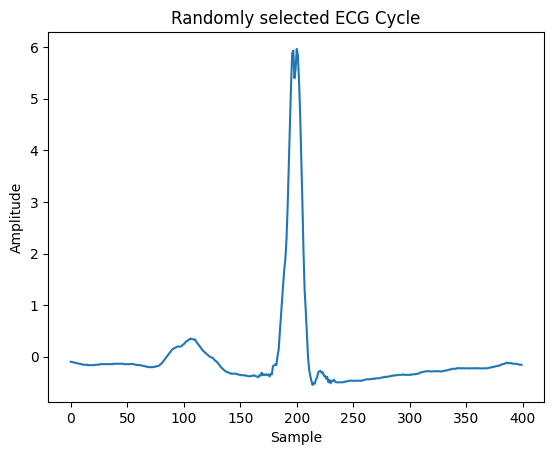

In [23]:
ecg_cycles = load_ecg_cycles(data_dir, lead=lead, cycle_len=cycle_len)
print(f"Loaded {len(ecg_cycles)} cycles")
print(f"The shape is{ecg_cycles.shape}")

ecg_cycles = (ecg_cycles - np.mean(ecg_cycles, axis=1, keepdims=True)) / (np.std(ecg_cycles, axis=1, keepdims=True) + 1e-8)

if len(ecg_cycles) == 0:
    raise ValueError("No ECG cycles found. Check your data or peak detection.")

plt.plot(ecg_cycles[np.random.randint(len(ecg_cycles))])
plt.title("Randomly selected ECG Cycle")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [25]:
X = ecg_cycles.reshape(-1, cycle_len, 1)
X = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)

X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [26]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
        )
        self.conv5 = nn.Sequential(
            nn.MaxPool1d(2),
            nn.Conv1d(32, 1, kernel_size=3, padding=1),
        )

        self.fc_branch = nn.Sequential(
            nn.Linear(400, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 25)
        )

        self.fc_h = nn.Sequential(
            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
        )
        self.fc_mu = nn.Linear(50, 25)
        self.fc_log_var = nn.Linear(50, 25)

    def forward(self, x):
        x_conv = self.conv1(x)
        x_conv = self.conv2(x_conv)
        x_conv = self.conv3(x_conv)
        x_conv = self.conv4(x_conv)
        x_conv = self.conv5(x_conv)
        x_conv = x_conv.view(x_conv.size(0), -1)

        x_flat = x.view(x.size(0), -1)
        x_fc = self.fc_branch(x_flat)

        x_combined = torch.cat([x_conv, x_fc], dim=1)

        h = self.fc_h(x_combined)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return mu, log_var, z

In [27]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_path = nn.Sequential(
            nn.Linear(25, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 400)
        )

        self.upsample_path = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv1d(8, 1, kernel_size=3, padding=1)
        )

        self.final = nn.Sequential(
            nn.Linear(800, 400),
        )

    def forward(self, z):
        fc_out = self.fc_path(z)
        x = z.view(z.size(0), 1, 25)
        conv_out = self.upsample_path(x)
        conv_out = conv_out.view(conv_out.size(0), -1)
        combined = torch.cat([fc_out, conv_out], dim=1)
        output = self.final(combined)
        output = output.unsqueeze(1)
        return output

In [28]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = 0.0
        self.reconstruction_loss_tracker = 0.0
        self.kl_loss_tracker = 0.0

    def forward(self, x):
        mu, log_var, z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

    def compute_loss(self, x, mu, log_var, z):
        x_recon = self.decoder(z)
        recon_loss = F.mse_loss(x_recon, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss

    def train_step(self, data, optimizer):
        self.train()
        optimizer.zero_grad()
        mu, log_var, z = self.encoder(data)
        loss, recon_loss, kl_loss = self.compute_loss(data, mu, log_var, z)
        loss.backward()
        optimizer.step()

        self.total_loss_tracker = loss.item()
        self.reconstruction_loss_tracker = recon_loss.item()
        self.kl_loss_tracker = kl_loss.item()

        return {
            "total_loss": self.total_loss_tracker,
            "reconstruction_loss": self.reconstruction_loss_tracker,
            "kl_loss": self.kl_loss_tracker,
        }

    def test_step(self, data):
        self.eval()
        with torch.no_grad():
            mu, log_var, z = self.encoder(data)
            loss, recon_loss, kl_loss = self.compute_loss(data, mu, log_var, z)

        self.total_loss_tracker = loss.item()
        self.reconstruction_loss_tracker = recon_loss.item()
        self.kl_loss_tracker = kl_loss.item()

        return {
            "total_loss": self.total_loss_tracker,
            "reconstruction_loss": self.reconstruction_loss_tracker,
            "kl_loss": self.kl_loss_tracker,
        }

In [29]:
vae = VAE(Encoder(), Decoder()).to(device)

In [30]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 720

In [31]:
train_total_losses = []
val_total_losses = []
train_recon_losses = []
val_recon_losses = []
train_kl_losses = []
val_kl_losses = []

In [32]:
for epoch in range(1, num_epochs + 1):
    vae.train()
    train_losses, train_recons, train_kls = [], [], []

    for batch in train_loader:
        x = batch[0].to(device)
        loss_dict = vae.train_step(x, optimizer)
        train_losses.append(loss_dict["total_loss"])
        train_recons.append(loss_dict["reconstruction_loss"])
        train_kls.append(loss_dict["kl_loss"])

    vae.eval()
    val_losses, val_recons, val_kls = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            loss_dict = vae.test_step(x)
            val_losses.append(loss_dict["total_loss"])
            val_recons.append(loss_dict["reconstruction_loss"])
            val_kls.append(loss_dict["kl_loss"])

    avg_train_total = sum(train_losses) / len(train_losses)
    avg_val_total = sum(val_losses) / len(val_losses)
    avg_train_recon = sum(train_recons) / len(train_recons)
    avg_val_recon = sum(val_recons) / len(val_recons)
    avg_train_kl = sum(train_kls) / len(train_kls)
    avg_val_kl = sum(val_kls) / len(val_kls)

    train_total_losses.append(avg_train_total)
    val_total_losses.append(avg_val_total)
    train_recon_losses.append(avg_train_recon)
    val_recon_losses.append(avg_val_recon)
    train_kl_losses.append(avg_train_kl)
    val_kl_losses.append(avg_val_kl)

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {avg_train_total:.4f} "
          f"(Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f}) | "
          f"Val Loss: {avg_val_total:.4f} "
          f"(Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})")

Epoch 1/720 | Train Loss: 0.6409 (Recon: 0.5974, KL: 0.0435) | Val Loss: 0.5522 (Recon: 0.5063, KL: 0.0460)
Epoch 2/720 | Train Loss: 0.5508 (Recon: 0.5023, KL: 0.0485) | Val Loss: 0.5369 (Recon: 0.4730, KL: 0.0638)
Epoch 3/720 | Train Loss: 0.5370 (Recon: 0.4704, KL: 0.0666) | Val Loss: 0.5437 (Recon: 0.4648, KL: 0.0789)
Epoch 4/720 | Train Loss: 0.5258 (Recon: 0.4533, KL: 0.0725) | Val Loss: 0.4986 (Recon: 0.4182, KL: 0.0804)
Epoch 5/720 | Train Loss: 0.5108 (Recon: 0.4293, KL: 0.0815) | Val Loss: 0.4992 (Recon: 0.4163, KL: 0.0829)
Epoch 6/720 | Train Loss: 0.4950 (Recon: 0.4119, KL: 0.0830) | Val Loss: 0.4924 (Recon: 0.4083, KL: 0.0842)
Epoch 7/720 | Train Loss: 0.4979 (Recon: 0.4132, KL: 0.0847) | Val Loss: 0.4902 (Recon: 0.4063, KL: 0.0839)
Epoch 8/720 | Train Loss: 0.4923 (Recon: 0.4035, KL: 0.0888) | Val Loss: 0.4751 (Recon: 0.3836, KL: 0.0915)
Epoch 9/720 | Train Loss: 0.4868 (Recon: 0.3988, KL: 0.0880) | Val Loss: 0.4642 (Recon: 0.3783, KL: 0.0859)
Epoch 10/720 | Train Loss: 0

In [35]:
torch.save(vae.state_dict(), "vae_ecg_model.pth")

In [36]:
vae = VAE(Encoder(), Decoder()).to(device)
vae.load_state_dict(torch.load("vae_ecg_model.pth"))
vae.eval()

VAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv1d(32, 32,

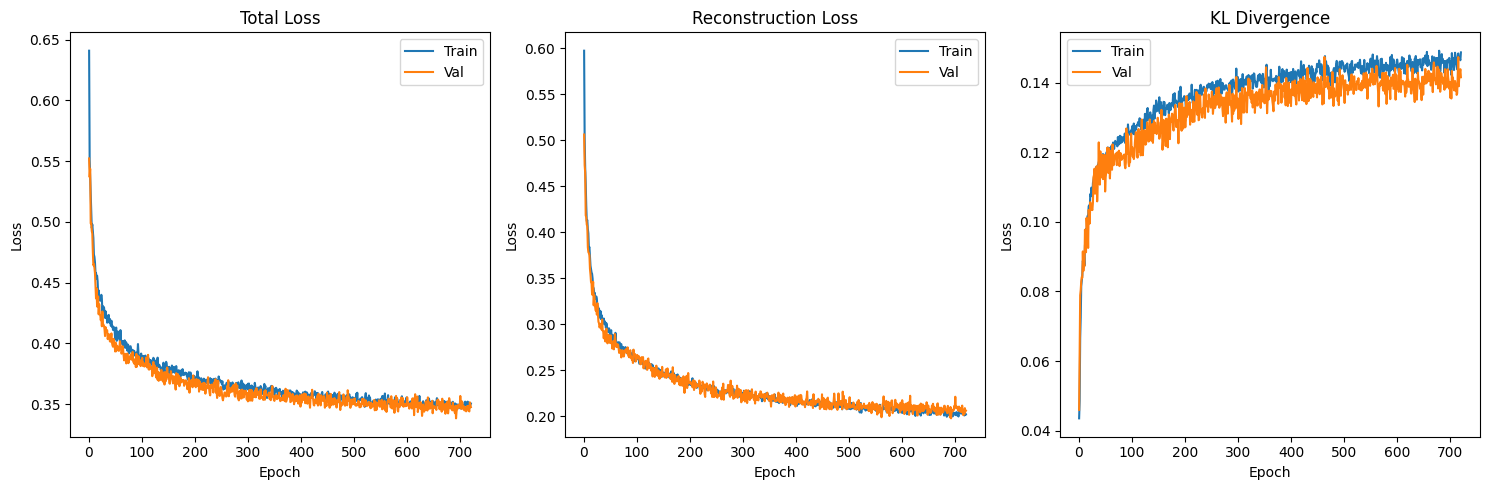

In [37]:
epochs = range(1, len(train_total_losses) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_total_losses, label='Train')
plt.plot(epochs, val_total_losses, label='Val')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_recon_losses, label='Train')
plt.plot(epochs, val_recon_losses, label='Val')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, train_kl_losses, label='Train')
plt.plot(epochs, val_kl_losses, label='Val')
plt.title('KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
vae.eval()
with torch.no_grad():
    for batch in val_loader:
        x = batch[0].to(device)
        x_recon = vae(x)
        break

x = x.cpu().numpy()
x_recon = x_recon.cpu().numpy()

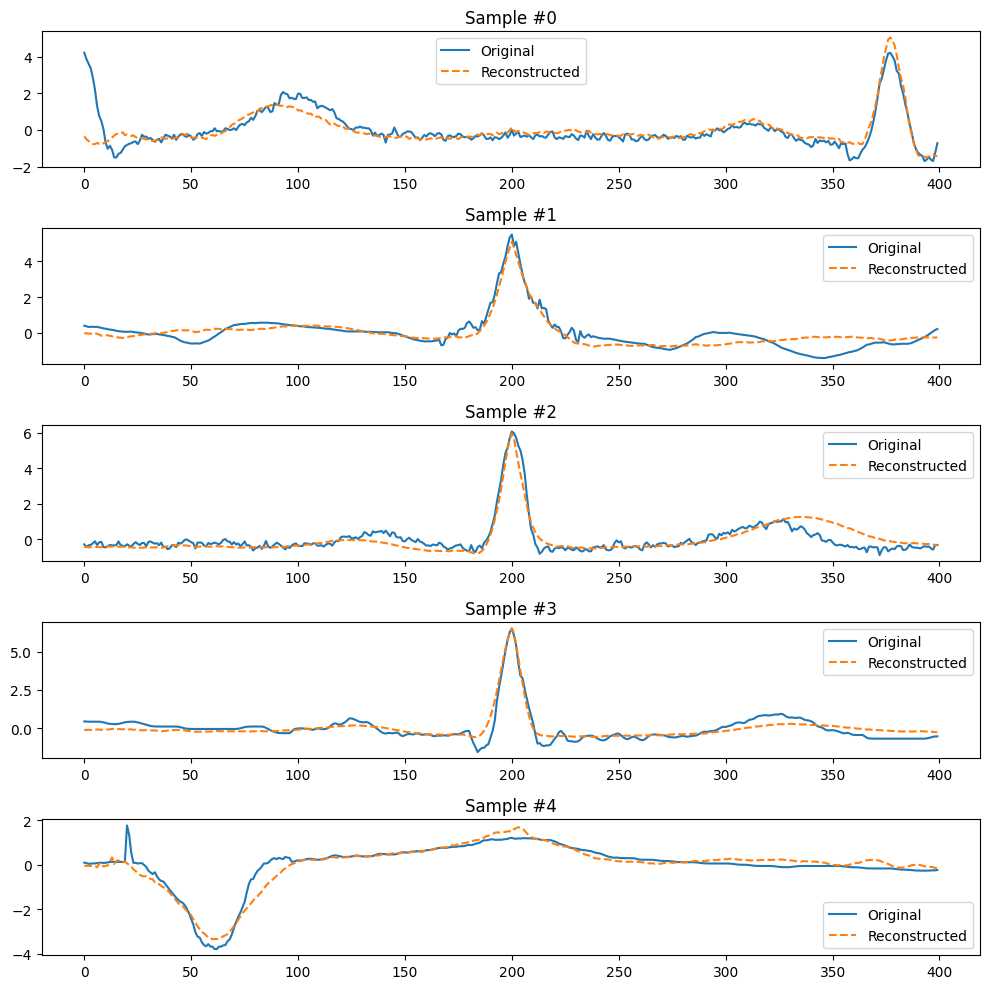

In [39]:
num_samples = 5
plt.figure(figsize=(10, num_samples * 2))

for i in range(num_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(x[i][0], label='Original', linewidth=1.5)
    plt.plot(x_recon[i][0], label='Reconstructed', linestyle='--')
    plt.title(f"Sample #{i}")
    plt.legend()

plt.tight_layout()
plt.show()

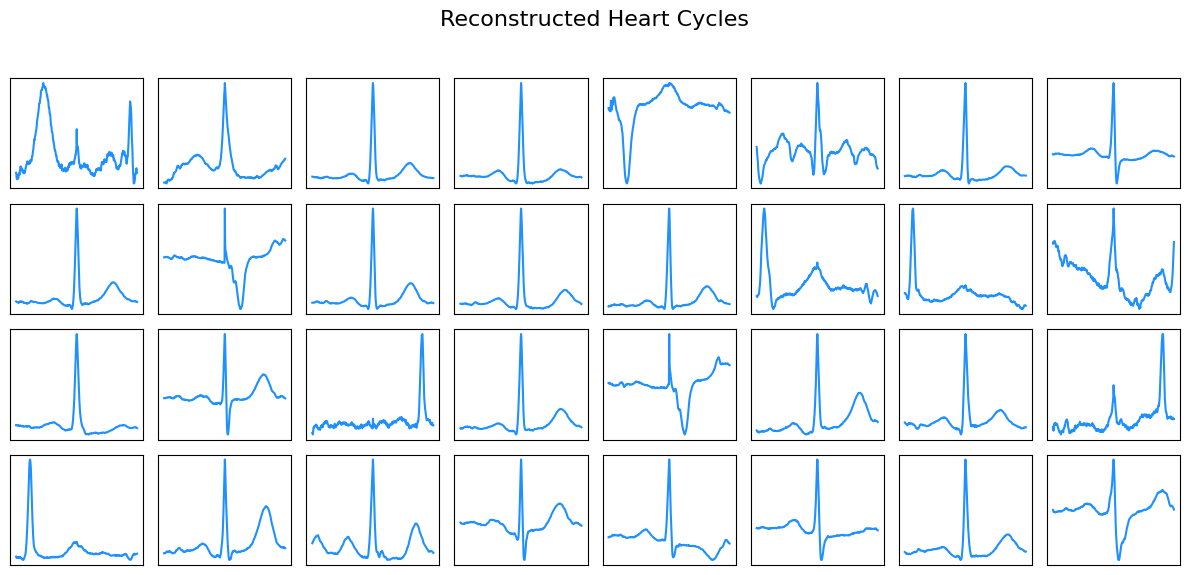

In [40]:
vae.eval()
num_samples = 32

with torch.no_grad():
    x = next(iter(val_loader))[0][:num_samples].to(device)
    x_recon = vae(x)

x_recon = x_recon.cpu().numpy()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    ax.plot(x_recon[i].squeeze(), color='dodgerblue')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('')

plt.suptitle("Reconstructed Heart Cycles", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

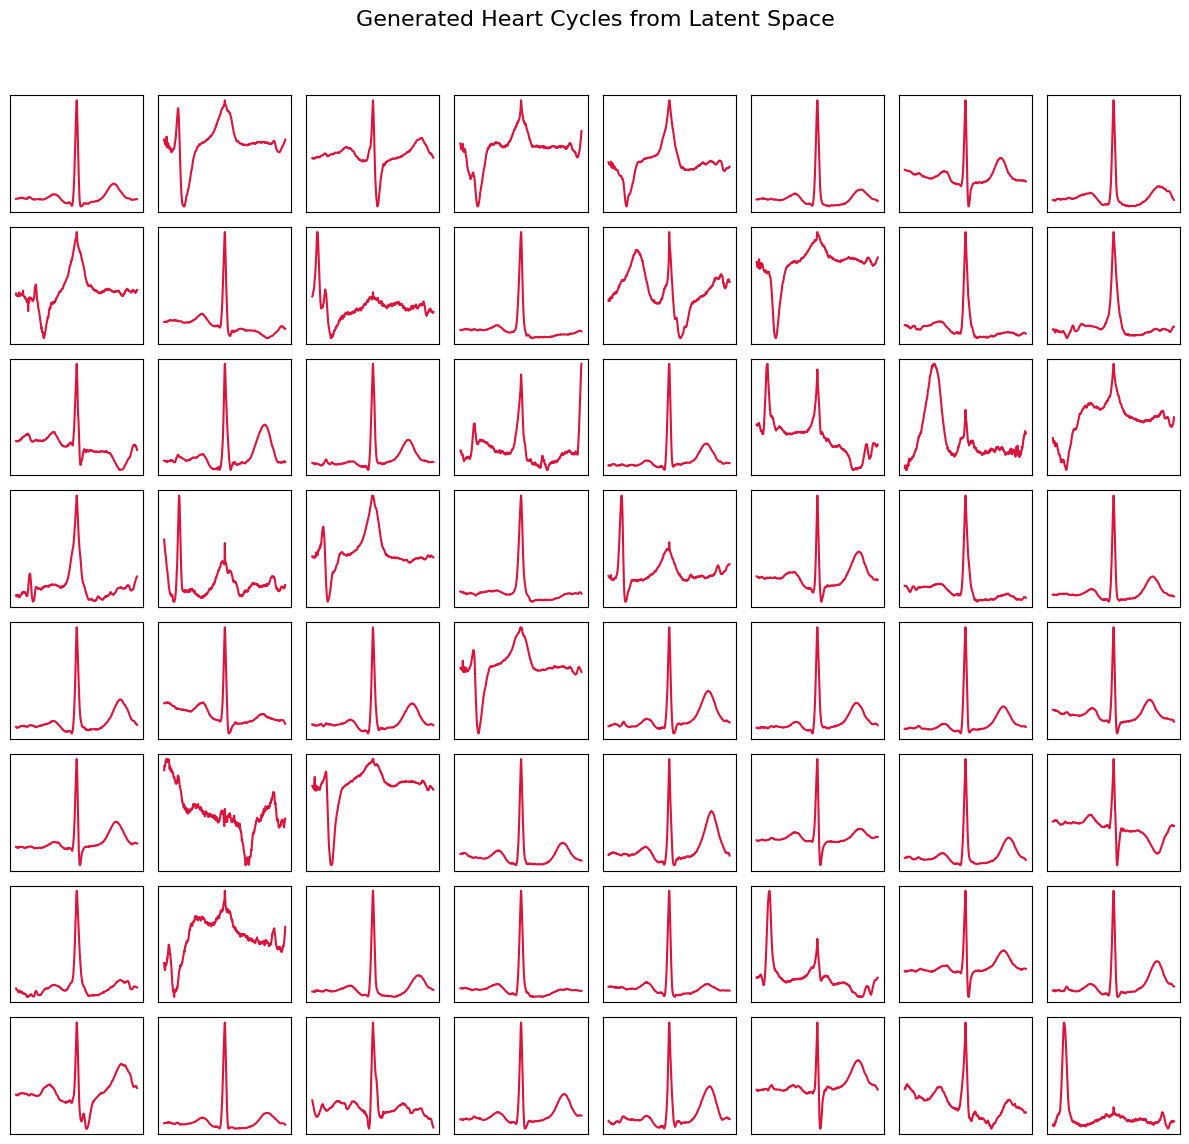

In [41]:
vae.eval()
num_samples = 64

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated = vae.decoder(z)

generated = generated.cpu().numpy()

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axes.flat):
    ax.plot(generated[i].squeeze(), color='crimson')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('')

plt.suptitle("Generated Heart Cycles from Latent Space", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [42]:
def compute_reconstruction_error(vae, dataloader):
    vae.eval()
    errors = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            x_recon = vae(x)
            batch_errors = F.l1_loss(x_recon, x, reduction='none')
            batch_errors = batch_errors.mean(dim=[1, 2])
            errors.extend(batch_errors.cpu().numpy())

    return np.array(errors)

In [43]:
errors = compute_reconstruction_error(vae, val_loader)

print("Reconstruction error stats:")
print(f"Mean error: {np.mean(errors):.4f}")
print(f"Max error: {np.max(errors):.4f}")
print(f"Min error: {np.min(errors):.4f}")

Reconstruction error stats:
Mean error: 0.3104
Max error: 0.7351
Min error: 0.1123


In [44]:
def compute_mmd(x, y, sigma=1.0):
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)

    def gaussian_kernel(a, b):
        a_norm = a.pow(2).sum(1).view(-1, 1)
        b_norm = b.pow(2).sum(1).view(1, -1)
        dist = a_norm + b_norm - 2.0 * torch.mm(a, b.t())
        return torch.exp(-dist / (2 * sigma ** 2))

    Kxx = gaussian_kernel(x, x)
    Kyy = gaussian_kernel(y, y)
    Kxy = gaussian_kernel(x, y)

    mmd = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return mmd.item()

In [45]:
vae.eval()
num_samples = 3000

real_ecgs = []
with torch.no_grad():
    for batch in val_loader:
        x = batch[0].to(device)
        real_ecgs.append(x)
        if sum(t.size(0) for t in real_ecgs) >= num_samples:
            break
    real_ecgs = torch.cat(real_ecgs, dim=0)[:num_samples]

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated_ecgs = vae.decoder(z)

In [46]:
mmd_score = compute_mmd(real_ecgs, generated_ecgs)
print(f"MMD score (real vs generated): {mmd_score:.6f}")

MMD score (real vs generated): 0.003218


In [47]:
def find_best_sigma(real_ecgs, generated_ecgs, sigma_values):
    best_sigma = None
    best_mmd = float('inf')
    mmd_scores = []

    for sigma in sigma_values:
        mmd = compute_mmd(real_ecgs, generated_ecgs, sigma=sigma)
        mmd_scores.append((sigma, mmd))
        if mmd < best_mmd:
            best_mmd = mmd
            best_sigma = sigma

    return best_sigma, best_mmd, mmd_scores

In [48]:
sigma_values = [0.04, 0.05, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
best_sigma, best_mmd, mmd_scores = find_best_sigma(real_ecgs, generated_ecgs, sigma_values)

print(f"Best sigma: {best_sigma}")
print(f"Best MMD: {best_mmd:.6f}")

Best sigma: 0.2
Best MMD: 0.002235


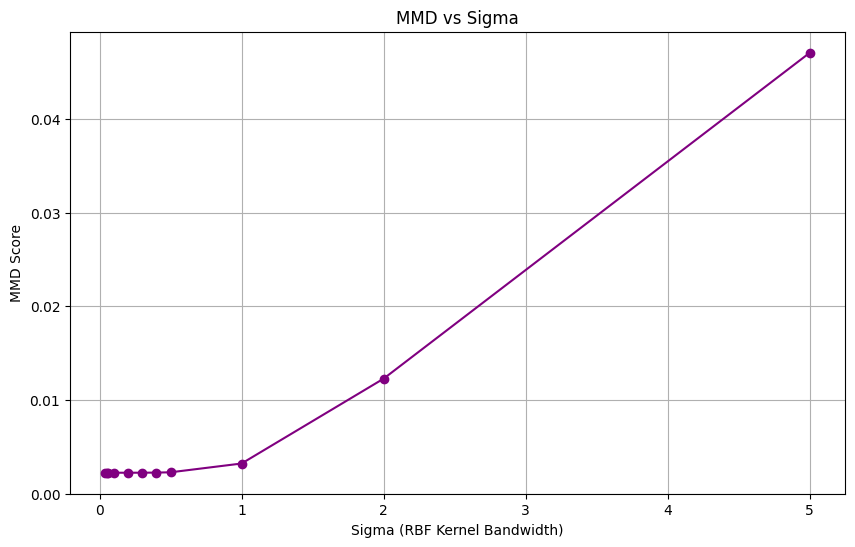

In [49]:
plt.figure(figsize=(10, 6))

sigmas, mmds = zip(*mmd_scores)
plt.plot(sigmas, mmds, marker='o', color='purple')
plt.xlabel("Sigma (RBF Kernel Bandwidth)")
plt.ylabel("MMD Score")
plt.title("MMD vs Sigma")
plt.grid()
plt.show()

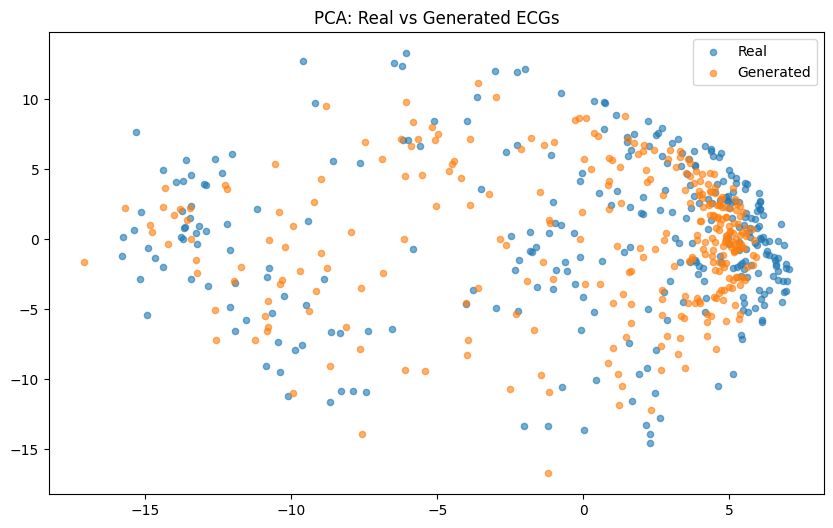

In [50]:
vae.eval()
num_samples = 300

real_ecgs = []
with torch.no_grad():
    for batch in val_loader:
        x = batch[0].to(device)
        real_ecgs.append(x)
        if sum(t.size(0) for t in real_ecgs) >= num_samples:
            break
    real_ecgs = torch.cat(real_ecgs, dim=0)[:num_samples]

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(real_ecgs.device)
    generated_ecgs = vae.decoder(z)

real_np = real_ecgs.view(num_samples, -1).cpu().numpy()
gen_np = generated_ecgs.view(num_samples, -1).cpu().numpy()

combined = np.vstack([real_np, gen_np])
labels = ['Real'] * num_samples + ['Generated'] * num_samples

pca = PCA(n_components=2).fit_transform(combined)

plt.figure(figsize=(10, 6))
for label in ['Real', 'Generated']:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(pca[idx, 0], pca[idx, 1], label=label, alpha=0.6, s=20)
plt.title("PCA: Real vs Generated ECGs")
plt.legend()
plt.show()